In [46]:
import cv2                 # working with, mainly resizing, images
import pandas as pd
import numpy as np         # dealing with arrays
import matplotlib.pyplot as plt
import seaborn as sns
import os                  # dealing with directories
import random                # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

import xgboost
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt, matplotlib.image as mpimg

In [119]:
DATA_DIR = r'C:\Users\idank\CourseProject\train'
LR = 1e-3

def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]
    
def create_train_data(img_size, file_name, color = False):
    data = []
    for img in tqdm(os.listdir(DATA_DIR)):
        label = label_img(img)
        path = os.path.join(DATA_DIR,img)
        if (color == False):
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(path)
        img = cv2.resize(img, (img_size,img_size))
        data.append([np.array(img),np.array(label)])
    random.Random(42).shuffle(data)
    np.save(file_name, data)
    return data
# If you have already created the dataset:
#train_data = np.load('file_name.npy')

### I will make 2 sets of X data, 50 * 50 images and 100 * 100 images
#### maybe there will be a different, I will check

In [3]:
data_50 = np.load(r'train_data_50.npy', allow_pickle=True)

In [4]:
data_100 = np.load(r'train_data_100.npy', allow_pickle=True)

In [5]:
X_50_50 = np.array([i[0] for i in data_50]).reshape(25000,2500)
X_100_100 = np.array([i[0] for i in data_100]).reshape(25000,10000)
Y = pd.Series([i[1][0] for i in data_50]) # dog=0. cat=1

# normalaize the data:
X_100_100 = X_100_100/255.
X_50_50 = X_50_50/255.

In [6]:
pd.DataFrame(X_50_50)

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.823529,0.482353,0.490196,0.466667,0.521569,0.517647,0.517647,0.517647,0.560784,0.474510,...,0.270588,0.247059,0.152941,0.192157,0.168627,0.149020,0.184314,0.145098,0.247059,0.552941
1,0.482353,0.501961,0.498039,0.521569,0.513725,0.521569,0.552941,0.521569,0.498039,0.388235,...,0.525490,0.545098,0.576471,0.631373,0.619608,0.607843,0.615686,0.584314,0.572549,0.560784
2,0.635294,0.674510,0.760784,0.839216,0.886275,0.764706,0.729412,0.698039,0.709804,0.541176,...,0.596078,0.564706,0.517647,0.537255,0.466667,0.482353,0.521569,0.509804,0.419608,0.462745
3,0.372549,0.337255,0.345098,0.407843,0.431373,0.337255,0.364706,0.341176,0.333333,0.372549,...,0.850980,0.819608,0.796078,0.796078,0.772549,0.811765,0.768627,0.635294,0.776471,0.749020
4,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.164706,0.164706,0.168627,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.078431,0.070588,0.086275,0.082353,0.082353,0.078431,0.082353,0.082353,0.078431,0.078431,...,0.666667,0.647059,0.709804,0.741176,0.392157,0.760784,0.682353,0.556863,0.619608,0.560784
24996,0.654902,0.650980,0.654902,0.658824,0.666667,0.682353,0.682353,0.647059,0.682353,0.698039,...,0.776471,0.949020,0.360784,0.521569,0.478431,0.588235,0.552941,0.600000,0.564706,0.815686
24997,0.396078,0.486275,0.498039,0.545098,0.517647,0.576471,0.466667,0.572549,0.615686,0.458824,...,0.576471,0.525490,0.647059,0.501961,0.662745,0.592157,0.596078,0.584314,0.650980,0.501961
24998,0.600000,0.592157,0.572549,0.564706,0.556863,0.556863,0.537255,0.537255,0.533333,0.513725,...,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.996078


In [7]:
images_50_50 = pd.DataFrame(X_50_50)
images_100_100 = pd.DataFrame(X_100_100)

# this function plot image from the data
def image_plot(images_set, Y_labels, image_number, size=50):
    images = images_set.values
    images = images.reshape(-1, size, size)
    img = images[image_number]
    plt.imshow(img,cmap='gray')
    plt.title("class " + str(Y_labels.iloc[image_number]))

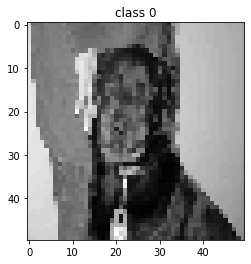

In [10]:
# 50*50 dog for example:
image_plot(images_50_50, Y, 0)

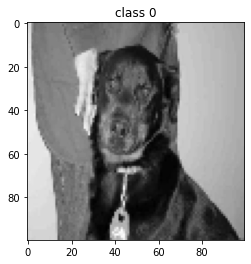

In [12]:
# 100*100 dog for example:
image_plot(images_100_100, Y, 0, 100)

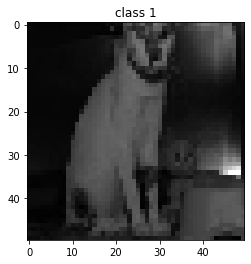

In [11]:
# 50*50 cat for example:
image_plot(images_50_50, Y, 5)

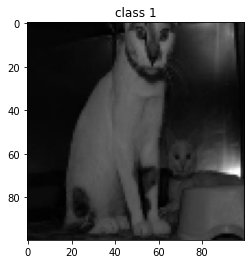

In [13]:
# 100*100 cat for example:
image_plot(images_100_100, Y, 5, 100)

In [8]:
# this function will help me check running time for each algorithem

from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_50_50, Y, test_size=0.15, random_state = 42)

### PCA Dimensionality Reductioin
- from 2500 features to 290
- 90% of the information remains

In [140]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

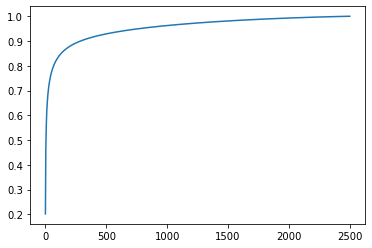

In [141]:
# the elbow is around 0.9 explaind varince, so this is a good point to use.
plt.plot(cumsum)

In [11]:
pca = PCA(n_components= 0.9)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [143]:
print("from 2500 features we have now only " + str(len(X_train_pca[0])) + " features which remains 0.9 from the information (variance) of the original data!")

from 2500 features we have now only 290 features which remains 0.9 from the information (variance) of the original data!


In [25]:
# for quick trained instead the hole train set
X_sample = X_train_pca[:6000]
y_sample = y_train[:6000]

## function that will return the accuracy of trained model using cross validation:

In [36]:
def cv_model_score(model, X=X_train_pca, Y=y_train, messege=True):
    if (messege==True):
        start_time = timer(None) # timing starts from this point for "start_time" variable
    scores = cross_val_score(model, X, Y, cv=3, scoring='accuracy')
    if (messege == True):
        timer(start_time) # timing ends here for "start_time" variable
        print("CV mean accuracy score is: " + str(scores.mean()))
    return scores.mean()

### Rendom Forest with the train set before PCA:

In [21]:
RFC = RandomForestClassifier()

cv_model_score(RFC, X_train, y_train)


 Time taken: 0 hours 2 minutes and 55.41 seconds.
CV mean accuracy score is: 0.6346351862069226


0.6346351862069226

### Rendom Forest with the train set after PCA:

In [18]:
RFC_pca = RandomForestClassifier()

cv_model_score(RFC_pca)


 Time taken: 0 hours 1 minutes and 21.41 seconds.
CV mean accuracy score is: 0.5991057499261466


0.5991057499261466

### Rendom Forest with the train set using kmeans (instead PCA):

In [17]:
RFC_kmeans = Pipeline([
    ("kmeans", KMeans(n_clusters=10)), 
    ("RFC", RandomForestClassifier())
])

cv_model_score(RFC_kmeans, X_train, y_train)


 Time taken: 0 hours 2 minutes and 12.42 seconds.
CV mean accuracy score is: 0.5630584362836725


0.5630584362836725

### XGBOOST with the train set before PCA:

In [ ]:
xgb = xgboost.XGBClassifier(use_label_encoder=False)

cv_model_score(xgb_pca, X_train, y_train)

### XGBOOST with the train set after PCA:

In [22]:
xgb_pca = xgboost.XGBClassifier(use_label_encoder=False)

cv_model_score(xgb_pca)

[17:28:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 2 minutes and 41.21 seconds.
CV mean accuracy sc

0.6238118649035173

### XGBOOST with the train set using kmeans (instead PCA):

In [19]:
xgb_kmeans = Pipeline([
    ("kmeans", KMeans(n_clusters=16)), 
    ("xgboost", xgboost.XGBClassifier(use_label_encoder=False))
])

cv_model_score(xgb_kmeans, X_train, y_train)

[17:21:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 2 minutes and 37.63 seconds.
CV mean accuracy sc

0.568093887648056

### as we can see, the k-means models have a lower results. I will use from now just the PCA data for models.

#### find best learning rate for XGBOOST
- check on a small sample
- eta_values: 0.05, 0.1, 0.3, 0.5, 0.7, 1

In [23]:
X_test_sample =  X_train_pca[6001:8000]
y_test_sample = y_train[6001:8000]
eta_range =  [0.05, 0.1, 0.3, 0.5, 0.7, 1]
eta_mean_scores = []

for eta in eta_range:
    xgb_eta_search = xgboost.XGBClassifier(eta=eta, eval_set=[(X_test_sample, y_test_sample)], early_stopping_rounds=10, use_label_encoder=False)
    scores = cross_val_score(xgb_eta_search, X_sample, y_sample, cv=3, scoring='accuracy')
    eta_mean_scores.append(scores.mean())

[13:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds", "eval_set" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:57:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds", "eval_set" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down 

[14:05:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
pd.Series(eta_mean_scores, eta_range)

0.05    0.631859
0.10    0.630212
0.30    0.623624
0.50    0.612518
0.70    0.603859
1.00    0.593459
dtype: float64

- best eta for now: 0.05 
- check again with low eta_values: 0.01, 0.03, 0.05

In [32]:
X_test_sample =  X_train_pca[6001:8000]
y_test_sample = y_train[6001:8000]
eta_range =  [0.01, 0.03, 0.05]
eta_mean_scores = []

for eta in eta_range:
    xgb_eta_search = xgboost.XGBClassifier(eta=eta, eval_set=[(X_test_sample, y_test_sample)], early_stopping_rounds=10, use_label_encoder=False)
    scores = cross_val_score(xgb_eta_search, X_sample, y_sample, cv=3, scoring='accuracy')
    eta_mean_scores.append(scores.mean())
    
pd.Series(eta_mean_scores, eta_range)

[14:17:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds", "eval_set" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds", "eval_set" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down 

0.01    0.611906
0.03    0.624282
0.05    0.631859
dtype: float64

In [35]:
best_eta = eta_range[np.argmax(eta_mean_scores)]
best_eta

0.05

In [43]:
XGB_pca_best_eta = xgboost.XGBClassifier(use_label_encoder=False, eta=best_eta)

cv_model_score(XGB_pca_best_eta)

[14:52:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:54:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 2 minutes and 54.12 seconds.
XGB CV mean accurac

#### Logistic Regression:

In [50]:
log_reg = LogisticRegression(random_state=15, max_iter=10000)

cv_model_score(log_reg)


 Time taken: 0 hours 0 minutes and 1.91 seconds.
CV mean accuracy score is: 0.5593411191582564


0.5593411191582564

#### linear svm:

In [53]:
LSVC = LinearSVC(random_state=6, C=1, tol=1e-5, loss="hinge", max_iter=100000)

cv_model_score(LSVC)

C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



 Time taken: 0 hours 1 minutes and 26.2 seconds.
CV mean accuracy score is: 0.5614587529398866


C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.5614587529398866

#### polynomial svm, degree of 2, kmeans instead of pca:

In [24]:
polynomial_svm_2 = Pipeline([
    ("kmeans", KMeans(n_clusters=12)),
    ("poly_features", PolynomialFeatures(degree=2)),
    ("svm_clf", LinearSVC(random_state=6, C=10, tol=1e-5, loss="hinge", max_iter=30000))
])

cv_model_score(polynomial_svm_2, X_train, y_train)

C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



 Time taken: 0 hours 10 minutes and 57.15 seconds.
CV mean accuracy score is: 0.5424955992880417


C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.5424955992880417

#### KNN:
-high score so I will check for best K

In [55]:
knn = KNeighborsClassifier(n_neighbors=100)

cv_model_score(knn)


 Time taken: 0 hours 2 minutes and 40.49 seconds.
CV mean accuracy score is: 0.600564602249592


0.600564602249592

best k for knn is around 45


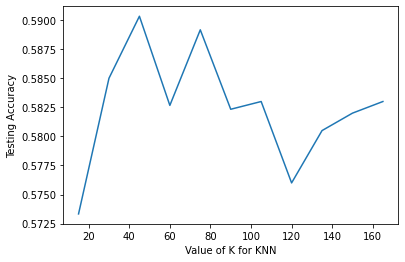

In [37]:
# try K=5 through K=180 and plot testing accuracy
# **using only sample!**
k_range = list(range(15, 180, 15))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cv_model_score(knn, X_sample, y_sample, messege=False))
    
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

best_k = k_range[np.argmax(scores)]
print("best k for knn is around " + str(best_k))

best k for knn is around 75


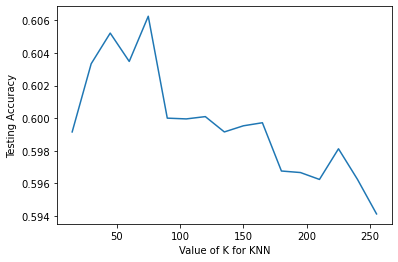

In [38]:
# try K=5 through K=180 and plot testing accuracy
# **using all train data!** because of the drastic changes in the sample graph

k_range = list(range(15, 270, 15))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cv_model_score(model=knn, messege=False))
    
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

best_k = k_range[np.argmax(scores)]
print("best k for knn is around " + str(best_k))

### Bagging models:

In [26]:
bag_log_reg = BaggingClassifier(
    LogisticRegression(random_state=15, max_iter=10000), bootstrap=True)

cv_model_score(bag_log_reg, X_sample, y_sample)


 Time taken: 0 hours 0 minutes and 8.37 seconds.
CV mean accuracy score is: 0.5323333333333333


0.5323333333333333

In [27]:
bag_svm = BaggingClassifier(
    LinearSVC(random_state=6, C=1, tol=1e-3, loss="hinge", max_iter=300000), bootstrap=True)

cv_model_score(bag_svm, X_sample, y_sample)


 Time taken: 0 hours 11 minutes and 53.79 seconds.
CV mean accuracy score is: 0.5273333333333333


0.5273333333333333

In [28]:
bag_XGB = BaggingClassifier(
    xgboost.XGBClassifier(use_label_encoder=False, eta=best_eta), bootstrap=True)

cv_model_score(bag_svm, X_sample, y_sample)


 Time taken: 0 hours 11 minutes and 59.11 seconds.
CV mean accuracy score is: 0.5363333333333333


0.5363333333333333

### Adaboost models:

In [29]:
ada_RFC = AdaBoostClassifier(RandomForestClassifier(), n_estimators=200, learning_rate=0.1)

cv_model_score(ada_RFC, X_sample, y_sample)


 Time taken: 0 hours 0 minutes and 19.09 seconds.
CV mean accuracy score is: 0.5801666666666666


0.5801666666666666

In [39]:
ada_RFC = AdaBoostClassifier(RandomForestClassifier(), n_estimators=200, learning_rate=0.3)

cv_model_score(ada_RFC)


 Time taken: 0 hours 1 minutes and 17.79 seconds.
CV mean accuracy score is: 0.6041883287615567


0.6041883287615567

### Voting model:

In [45]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('ada_RFC', ada_RFC), ('knn', KNeighborsClassifier(n_neighbors=best_k)), ('rfc', RFC_pca), ('xgb', xgboost.XGBClassifier(use_label_encoder=False, eta=best_eta))])
cv_model_score(voting_clf)


[21:36:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 13 minutes and 34.11 seconds.
CV mean accuracy s

0.6238588727953956

### Stacking models:

In [50]:
from sklearn.ensemble import StackingClassifier
estimators = [('ada_RFC', ada_RFC), ('knn', KNeighborsClassifier(n_neighbors=best_k)), ('rfc', RFC_pca), ('xgb', xgboost.XGBClassifier(use_label_encoder=False, eta=best_eta, eval_metric='mlogloss'))]
RFC_stacking = StackingClassifier(final_estimator=RandomForestClassifier(), estimators=estimators)
cv_model_score(RFC_stacking)


 Time taken: 0 hours 31 minutes and 37.72 seconds.
CV mean accuracy score is: 0.6084233638098065


0.6084233638098065

In [51]:

estimators = [('ada_RFC', ada_RFC), ('knn', KNeighborsClassifier(n_neighbors=best_k)), ('rfc', RFC_pca), ('xgb', xgboost.XGBClassifier(use_label_encoder=False, eta=best_eta, eval_metric='mlogloss'))]
RFC_stacking = StackingClassifier(final_estimator=LogisticRegression(max_iter=20000), estimators=estimators)
cv_model_score(RFC_stacking)


 Time taken: 0 hours 31 minutes and 46.0 seconds.
CV mean accuracy score is: 0.6461174284775191


0.6461174284775191

In [51]:
from sklearn.ensemble import StackingClassifier
estimators = [('ada_RFC', ada_RFC), ('knn', KNeighborsClassifier(n_neighbors=best_k)), ('rfc', RFC_pca), ('xgb', xgboost.XGBClassifier(use_label_encoder=False, eta=best_eta, eval_metric='mlogloss'))]
RFC_stacking = StackingClassifier(final_estimator=LogisticRegression(max_iter=20000), estimators=estimators)
cv_model_score(RFC_stacking)


 Time taken: 0 hours 31 minutes and 46.0 seconds.
CV mean accuracy score is: 0.6461174284775191


0.6461174284775191

# Stacing model training in sklearn is very slow, so I made my own version of STACKING!

In [58]:
X_step1 = X_train_pca[:15000]
X_step2 = X_train_pca[15000:]

Y_step1 = y_train[:15000]
Y_step2 = y_train[15000:]

ada_RFC.fit(X_step1, Y_step1)
knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_step1, Y_step1)
RFC_pca.fit(X_step1, Y_step1)
xgb = xgboost.XGBClassifier(use_label_encoder=False, eta=best_eta, eval_metric='mlogloss').fit(X_step1, Y_step1)

ada_RFC_predict = ada_RFC.predict(X_step2)
knn_predict = knn.predict(X_step2)
RFC_predict = RFC_pca.predict(X_step2)
xgb_predict = xgb.predict(X_step2)

ada_RFC_predict_prob = ada_RFC.predict_proba(X_step2)
knn_predict_prob = knn.predict_proba(X_step2)
RFC_predict_prob = RFC_pca.predict_proba(X_step2)
xgb_predict_prob = xgb.predict_proba(X_step2)

In [72]:
x1 = np.array([i[0] for i in ada_RFC_predict_prob])
x2 = np.array([i[0] for i in knn_predict_prob])
x3 = np.array([i[0] for i in RFC_predict_prob])
x4 = np.array([i[0] for i in xgb_predict_prob])

In [97]:
predicts = pd.DataFrame({'x1': ada_RFC_predict,'x2': knn_predict,'x3': RFC_predict,'x4': xgb_predict, 'label': Y_step2})
X_step2_train_predicts = predicts.drop(columns=['label'])
predicts

,x1,x2,x3,x4,label
11357,1,0,1,0,1
19401,0,1,1,0,0
13668,1,1,0,1,0
14645,0,1,1,1,1
15706,1,0,0,0,0
...,...,...,...,...,...
21575,1,1,0,0,0
5390,1,0,1,0,0
860,1,0,1,1,1
15795,0,0,1,0,0


In [79]:
predicts_prob = pd.DataFrame({'x1': x1,'x2': x2,'x3': x3,'x4': x4, 'label': Y_step2})
X_step2_train = predicts_prob.drop(columns=['label'])
Y_step2_train = predicts_prob['label']
predicts_prob

,x1,x2,x3,x4,label
11357,0.38,0.640000,0.42,0.506005,1
19401,0.55,0.493333,0.44,0.555139,0
13668,0.47,0.453333,0.55,0.420189,0
14645,0.56,0.413333,0.45,0.457630,1
15706,0.49,0.706667,0.60,0.683840,0
...,...,...,...,...,...
21575,0.47,0.466667,0.51,0.563564,0
5390,0.47,0.560000,0.49,0.550673,0
860,0.40,0.560000,0.36,0.458295,1
15795,0.56,0.560000,0.46,0.577659,0


### stacking models with the final predicts of the estimators:

In [101]:
stacking_log_reg = LogisticRegression(max_iter=20000)
cv_model_score(stacking_log_reg, X_step2_train_predicts, Y_step2_train)


 Time taken: 0 hours 0 minutes and 0.03 seconds.
CV mean accuracy score is: 0.640962054888475


0.640962054888475

In [112]:
stacking_svm = LinearSVC(max_iter=30000)
cv_model_score(stacking_svm, X_step2_train_predicts, Y_step2_train)


 Time taken: 0 hours 0 minutes and 0.1 seconds.
CV mean accuracy score is: 0.640962054888475


0.640962054888475

### stacking models with the probabilities predicts of the estimators:

In [95]:
stacking_svm = LinearSVC(max_iter=30000)
cv_model_score(stacking_svm, X_step2_train, Y_step2_train)


 Time taken: 0 hours 0 minutes and 0.08 seconds.
CV mean accuracy score is: 0.6470420296038153


0.6470420296038153

In [86]:
stacking_log_reg = LogisticRegression(max_iter=20000)
cv_model_score(stacking_log_reg, X_step2_train, Y_step2_train)


 Time taken: 0 hours 0 minutes and 0.1 seconds.
CV mean accuracy score is: 0.6468819272120008


0.6468819272120008

In [96]:
stacking_adaboost = AdaBoostClassifier()
cv_model_score(stacking_adaboost, X_step2_train, Y_step2_train)


 Time taken: 0 hours 0 minutes and 0.58 seconds.
CV mean accuracy score is: 0.634722208144474


0.634722208144474

In [94]:
stacking_xgb = xgboost.XGBClassifier(use_label_encoder=False, eta=0.1, eval_metric='mlogloss')
cv_model_score(stacking_xgb, X_step2_train, Y_step2_train)

C:\Users\idank\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



 Time taken: 0 hours 0 minutes and 1.37 seconds.
CV mean accuracy score is: 0.6222410556898317


0.6222410556898317

In [93]:
stacking_RF = RandomForestClassifier()
cv_model_score(stacking_RF, X_step2_train, Y_step2_train)


 Time taken: 0 hours 0 minutes and 1.93 seconds.
CV mean accuracy score is: 0.6116805176352208


0.6116805176352208

# linear SVC stacking with probabilities is my best model. I will test it with the data test:

In [116]:
# fit the final model

stacking_svm = LinearSVC(max_iter=30000)
stacking_svm.fit(X_step2_train, Y_step2_train)

# prepare the final test set

ada_RFC_predict_prob = ada_RFC.predict_proba(X_test_pca)
knn_predict_prob = knn.predict_proba(X_test_pca)
RFC_predict_prob = RFC_pca.predict_proba(X_test_pca)
xgb_predict_prob = xgb.predict_proba(X_test_pca)

x1 = np.array([i[0] for i in ada_RFC_predict_prob])
x2 = np.array([i[0] for i in knn_predict_prob])
x3 = np.array([i[0] for i in RFC_predict_prob])
x4 = np.array([i[0] for i in xgb_predict_prob])

X_test_predicts_prob = pd.DataFrame({'x1': x1,'x2': x2,'x3': x3,'x4': x4})

y_predict = stacking_svm.predict(X_test_predicts_prob)
metrics.accuracy_score(y_predict, y_test)

0.6493333333333333

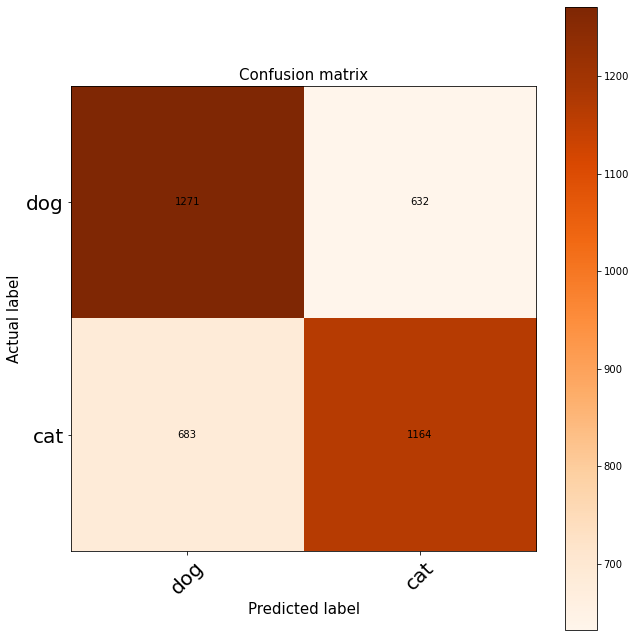

In [154]:
y_pred_series = pd.Series(y_predict, index = y_test.index)

cm = confusion_matrix(y_test, y_pred_series)
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Oranges')
plt.title('Confusion matrix ', size = 15)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['dog', 'cat'], rotation=45, size = 20)
plt.yticks(tick_marks, ['dog', 'cat'], size = 20)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

# I will check if there is difference between greyed images and colored images!

## Same process with colored img (data)

In [120]:
data_50_color = create_train_data(img_size=50, file_name="train_data_50", color=True)

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:35<00:00, 262.18it/s]


In [137]:
X_50_50 = np.array([i[0] for i in data_50_color]).reshape(25000,7500)

# normalaize the data:
X_50_50 = X_50_50/255.

In [138]:
pd.DataFrame(X_50_50)

,0,1,2,3,4,5,6,7,8,9,...,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499
0,0.717647,0.839216,0.831373,0.360784,0.352941,0.776471,0.349020,0.364706,0.792157,0.321569,...,0.207843,0.145098,0.133333,0.168627,0.164706,0.235294,0.298039,0.458824,0.541176,0.623529
1,0.423529,0.454902,0.560784,0.435294,0.474510,0.580392,0.427451,0.478431,0.568627,0.439216,...,0.654902,0.541176,0.572549,0.627451,0.525490,0.552941,0.615686,0.517647,0.545098,0.611765
2,0.572549,0.647059,0.635294,0.611765,0.686275,0.674510,0.694118,0.768627,0.764706,0.792157,...,0.545098,0.435294,0.513725,0.533333,0.360784,0.423529,0.435294,0.400000,0.466667,0.478431
3,0.149020,0.317647,0.564706,0.137255,0.278431,0.529412,0.121569,0.282353,0.552941,0.184314,...,0.835294,0.501961,0.623529,0.705882,0.639216,0.772549,0.835294,0.611765,0.745098,0.807843
4,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.070588,0.070588,0.094118,0.062745,0.062745,0.086275,0.078431,0.078431,0.101961,0.078431,...,0.658824,0.576471,0.568627,0.525490,0.627451,0.631373,0.596078,0.576471,0.564706,0.541176
24996,0.662745,0.654902,0.650980,0.658824,0.650980,0.647059,0.662745,0.654902,0.650980,0.666667,...,0.513725,0.705882,0.611765,0.545098,0.549020,0.552941,0.600000,0.678431,0.764706,0.964706
24997,0.223529,0.376471,0.505882,0.313725,0.462745,0.596078,0.329412,0.474510,0.607843,0.364706,...,0.709804,0.403922,0.564706,0.698039,0.470588,0.627451,0.764706,0.313725,0.474510,0.615686
24998,0.482353,0.619608,0.603922,0.474510,0.611765,0.596078,0.454902,0.588235,0.588235,0.439216,...,0.992157,0.984314,0.992157,0.992157,0.984314,0.992157,0.992157,0.988235,0.996078,0.996078


In [144]:
X_train, X_test, y_train, y_test = train_test_split(X_50_50, Y, test_size=0.15, random_state = 42)

### PCA Dimensionality Reductioin
- from 7500 features to 380
- 90% of the information remains

In [145]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

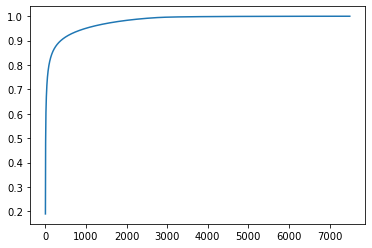

In [146]:
# the elbow is around 0.9 explaind varince, so this is a good point to use.
plt.plot(cumsum)

In [147]:
pca = PCA(n_components= 0.9)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [155]:
print("from 7500 features we have now only " + str(len(X_train_pca[0])) + " features which remains 0.9 from the information (variance) of the original data!")

from 7500 features we have now only 380 features which remains 0.9 from the information (variance) of the original data!


In [157]:
xgb_pca = xgboost.XGBClassifier(use_label_encoder=False, eval_matric = 'mlogloss')

cv_model_score(xgb_pca)

[14:26:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_matric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:26:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:27:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_matric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not

0.6238118649035173

In [159]:
len(X_test_pca[0])

380

In [160]:
X_step1 = X_train_pca[:15000]
X_step2 = X_train_pca[15000:]

Y_step1 = y_train[:15000]
Y_step2 = y_train[15000:]

ada_RFC.fit(X_step1, Y_step1)
knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_step1, Y_step1)
RFC_pca.fit(X_step1, Y_step1)
xgb = xgboost.XGBClassifier(use_label_encoder=False, eta=best_eta, eval_metric='mlogloss').fit(X_step1, Y_step1)

ada_RFC_predict_prob = ada_RFC.predict_proba(X_step2)
knn_predict_prob = knn.predict_proba(X_step2)
RFC_predict_prob = RFC_pca.predict_proba(X_step2)
xgb_predict_prob = xgb.predict_proba(X_step2)

x1 = np.array([i[0] for i in ada_RFC_predict_prob])
x2 = np.array([i[0] for i in knn_predict_prob])
x3 = np.array([i[0] for i in RFC_predict_prob])
x4 = np.array([i[0] for i in xgb_predict_prob])

predicts_prob = pd.DataFrame({'x1': x1,'x2': x2,'x3': x3,'x4': x4, 'label': Y_step2})
X_step2_train = predicts_prob.drop(columns=['label'])
Y_step2_train = predicts_prob['label']
predicts_prob

,x1,x2,x3,x4,label
11357,0.40,0.680000,0.41,0.440541,1
19401,0.52,0.546667,0.55,0.519661,0
13668,0.43,0.426667,0.49,0.426953,0
14645,0.49,0.426667,0.49,0.550027,1
15706,0.47,0.653333,0.52,0.502458,0
...,...,...,...,...,...
21575,0.51,0.413333,0.59,0.611326,0
5390,0.58,0.573333,0.50,0.485669,0
860,0.31,0.560000,0.33,0.378233,1
15795,0.51,0.586667,0.47,0.579007,0


### test with 2 of the Best greyed images models:

In [161]:
stacking_svm = LinearSVC(max_iter=30000)
cv_model_score(stacking_svm, X_step2_train, Y_step2_train)


 Time taken: 0 hours 0 minutes and 0.14 seconds.
CV mean accuracy score is: 0.6609612624392264


0.6609612624392264

In [162]:
stacking_log_reg = LogisticRegression(max_iter=20000)
cv_model_score(stacking_log_reg, X_step2_train, Y_step2_train)


 Time taken: 0 hours 0 minutes and 0.15 seconds.
CV mean accuracy score is: 0.660641288018751


0.660641288018751

# linear SVC stacking with probabilities is my best model (at greyed images). I will test it with the data test of colored images:

In [163]:
# fit the final model

stacking_svm = LinearSVC(max_iter=30000)
stacking_svm.fit(X_step2_train, Y_step2_train)

# prepare the final test set

ada_RFC_predict_prob = ada_RFC.predict_proba(X_test_pca)
knn_predict_prob = knn.predict_proba(X_test_pca)
RFC_predict_prob = RFC_pca.predict_proba(X_test_pca)
xgb_predict_prob = xgb.predict_proba(X_test_pca)

x1 = np.array([i[0] for i in ada_RFC_predict_prob])
x2 = np.array([i[0] for i in knn_predict_prob])
x3 = np.array([i[0] for i in RFC_predict_prob])
x4 = np.array([i[0] for i in xgb_predict_prob])

X_test_predicts_prob = pd.DataFrame({'x1': x1,'x2': x2,'x3': x3,'x4': x4})

y_predict = stacking_svm.predict(X_test_predicts_prob)
metrics.accuracy_score(y_predict, y_test)

0.6586666666666666

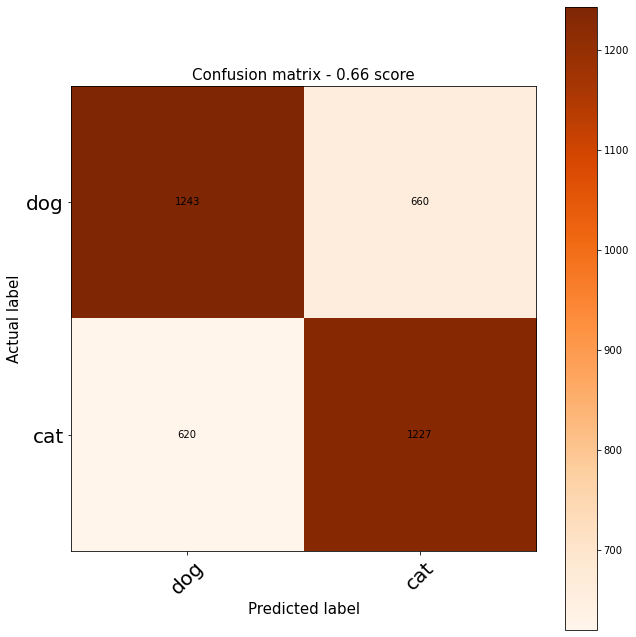

In [165]:
y_pred_series = pd.Series(y_predict, index = y_test.index)

cm = confusion_matrix(y_test, y_pred_series)
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Oranges')
plt.title('Confusion matrix - 0.66 score', size = 15)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['dog', 'cat'], rotation=45, size = 20)
plt.yticks(tick_marks, ['dog', 'cat'], size = 20)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

# same best model with PCA of 90%, has score of 0.65 in greyed images and score of 0.66 in colored images.
### in my opinion, this improvement is not worth 90 features more. but it depends on the target of the models and its resurces.